In [1]:
import tensorflow as tf

In [2]:
!nvidia-smi

Sat Feb  3 10:19:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-02-03 10:19:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-03 10:19:45 (22.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
import helper_functions as hlp

In [5]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 29.12 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.


In [6]:
path = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

def data_preprocessor(path):
  with open(path,'r') as f:
    text = f.readlines()

  data = []

  for i,line in enumerate(text):
    if line =='\n':
      for index in range(len(data)-line_no-1,len(data)):
        data[index]['total_lines'] = line_no

    elif line[0]=='#':
      line_no = -1

    else:
      line_no+=1
      target,text = line.split('\t')
      data.append({
        'line_no': line_no,
        'target':target,
        'text':text.splitlines()[0].lower(),
        'total_lines':0
      })

  return data

In [7]:
import pandas as pd
import time as time


tic = time.time()
test_data = data_preprocessor(path + 'test.txt')
dev_data = data_preprocessor(path + 'dev.txt')
train_data = data_preprocessor(path + 'train.txt')


test_df = pd.DataFrame(test_data)
dev_df = pd.DataFrame(dev_data)
train_df = pd.DataFrame(train_data)


X_test = test_df['text'].to_numpy()
X_dev = dev_df['text'].to_numpy()
X_train = train_df['text'].to_numpy()


y_test = test_df['target'].to_numpy()
y_dev = dev_df['target'].to_numpy()
y_train = train_df['target'].to_numpy()

print(f'{time.time()-tic:.2f}','sec')

2.46 sec


In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import numpy as np

encoder_onehot = OneHotEncoder(sparse_output = False)

y_train_encoded_onehot = encoder_onehot.fit_transform(y_train.reshape(-1,1))
y_test_encoded_onehot = encoder_onehot.transform(y_test.reshape(-1,1))
y_dev_encoded_onehot = encoder_onehot.transform(np.expand_dims(y_dev,1))


encoder_label = LabelEncoder()

y_train_encoded_label = encoder_label.fit_transform(y_train.reshape(-1,1))
y_test_encoded_label = encoder_label.transform(y_test.reshape(-1,1))
y_dev_encoded_label = encoder_label.transform(np.expand_dims(y_dev,1))

labels = encoder_label.classes_

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [9]:
# Visualize our data
for i in np.random.choice(len(X_train),10,replace=False):
  print(y_train[i],'\t',X_train[i])

RESULTS 	 the mobility of the tablet ( @ ) and the smartphone ( @ ) was seen as a significant advantage over the computer ( @ , p < @ ) .
METHODS 	 blood samples were collected on day @ , day @ , day @ and day @ .
METHODS 	 existing continuous benzodiazepine sedation was converted to dexmedetomidine or midazolam when patients qualified for daily awakenings .
BACKGROUND 	 home-based hypnotherapy by means of exercises on cd has been shown effective as well , and has potential benefits , such as lower costs and less time investment .
BACKGROUND 	 the program consists of phases targeting motivation ( dietary feedback and advice , analyzing reasons for health values , thinking about health-related desires , and concerns ) , volition ( implementation intentions with mental contrasting ) , and maintenance ( reviewing tasks , weekly tips ) .
METHODS 	 two weeks after the intervention , the victorian cancer registry sought permission from patients to release their contact details to researchers

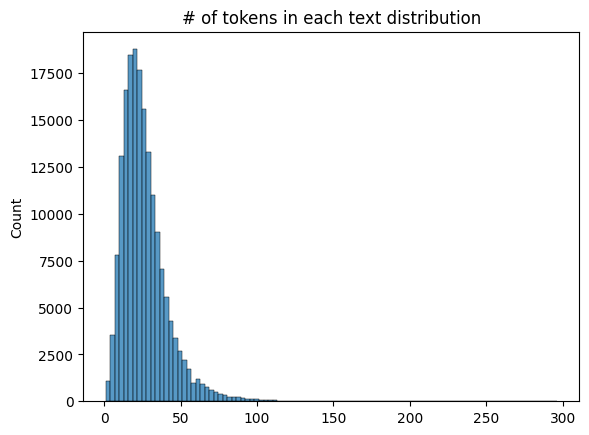

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(np.array(list(map(lambda x:len(x.split(' ')),X_train))),bins=100)
plt.title('# of tokens in each text distribution')
plt.show()

## Modeling

### 0 Naive Bays

In [11]:
def evaluate_model(y_test,y_pred,labels=None,text_size=8,figsize=(10,6)):
  print(classification_report(y_test,y_pred))
  print(confusion_matrix(y_test,y_pred))
  hlp.make_confusion_matrix(y_test,y_pred,classes=labels,text_size=text_size,figsize=figsize)

In [12]:
labels.tolist()

['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']

              precision    recall  f1-score   support

           0       0.65      0.47      0.54      3621
           1       0.63      0.58      0.60      4571
           2       0.72      0.88      0.79      9897
           3       0.74      0.13      0.22      2333
           4       0.76      0.85      0.80      9713

    accuracy                           0.72     30135
   macro avg       0.70      0.58      0.59     30135
weighted avg       0.71      0.72      0.69     30135

[[1688  859  759   88  227]
 [ 278 2642  391    7 1253]
 [ 103   77 8683    7 1027]
 [ 520  420  968  294  131]
 [  19  186 1215    3 8290]]


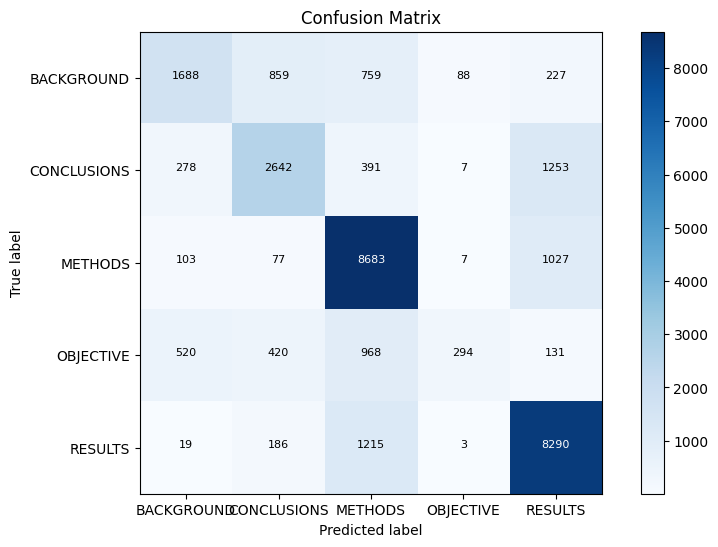

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.pipeline import Pipeline


model_0 = Pipeline([
    ('tokenizer',TfidfVectorizer()),
    ('NB',MultinomialNB())
])

model_0.fit(X = X_train,y = y_train_encoded_label)

y_pred = model_0.predict(X_test)
evaluate_model(y_test_encoded_label,y_pred,labels.tolist(),text_size=8,figsize=(10,6))

### 1 LSTM

In [14]:
text_length = 50
vocab_size = 60000

tokenizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=vocab_size,
                                                                         output_sequence_length = text_length)
tokenizer.adapt(X_train)

In [15]:
embedding = tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=128,input_length=text_length)

In [16]:
from tensorflow.keras.layers import Dense,LSTM,Bidirectional,GRU, GlobalMaxPool1D, Input,Conv1D,MaxPooling1D

# model_1 = tf.keras.models.Sequential([
#   tokenizer,
#   embedding,
#   Bidirectional(LSTM(64,return_sequences=True)),
#   Bidirectional(LSTM(64,return_sequences=True)),
#   GlobalMaxPool1D(),
#   Dense(64, activation='relu'),
#   Dense(64, activation='relu'),
#   Dense(5, activation='softmax')
# ])

# model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = 'adam',metrics=['accuracy'])
# model_1.summary()

In [17]:
# model_1.fit(X_train,y_train_encoded_onehot, epochs=3,batch_size=32*80,validation_data=(X_test,y_test_encoded_onehot))

In [18]:
# y_pred = np.argmax(model_1.predict(X_test),axis=1)


# evaluate_model(y_test_encoded_label,y_pred,labels.tolist(),text_size=8,figsize=(10,6))

### 2 CNN

In [19]:
train_data = tf.data.Dataset.from_tensor_slices((X_train,y_train_encoded_onehot))
test_data = tf.data.Dataset.from_tensor_slices((X_test,y_test_encoded_onehot))

In [20]:
train_data = train_data.batch(32*50).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(32*50).prefetch(tf.data.AUTOTUNE)

In [21]:
model_2 = tf.keras.models.Sequential([
    tokenizer,
    embedding,
    Conv1D(64,9,padding='same'),
    GlobalMaxPool1D(),
    Dense(64,activation='relu'),
    Dense(5,activation='softmax')

])

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 50)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 50, 128)           7680000   
                                                                 
 conv1d (Conv1D)             (None, 50, 64)            73792     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 5)                 3

In [22]:
model_2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_2.fit(train_data,epochs = 3,validation_data=test_data)

Epoch 1/3
113/113 [==============================] - 20s 127ms/step - loss: 0.9165 - accuracy: 0.6489 - val_loss: 0.5552 - val_accuracy: 0.7962
Epoch 2/3
113/113 [==============================] - 4s 34ms/step - loss: 0.4741 - accuracy: 0.8281 - val_loss: 0.5039 - val_accuracy: 0.8170
Epoch 3/3
113/113 [==============================] - 3s 29ms/step - loss: 0.3748 - accuracy: 0.8670 - val_loss: 0.5118 - val_accuracy: 0.8158


942/942 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.63      0.71      0.67      3621
           1       0.75      0.74      0.74      4571
           2       0.88      0.91      0.89      9897
           3       0.73      0.49      0.59      2333
           4       0.87      0.87      0.87      9713

    accuracy                           0.82     30135
   macro avg       0.77      0.74      0.75     30135
weighted avg       0.82      0.82      0.81     30135

[[2558  460  244  319   40]
 [ 445 3383  111   31  601]
 [ 152   75 9042   61  567]
 [ 858  134  166 1154   21]
 [  33  471  752    9 8448]]


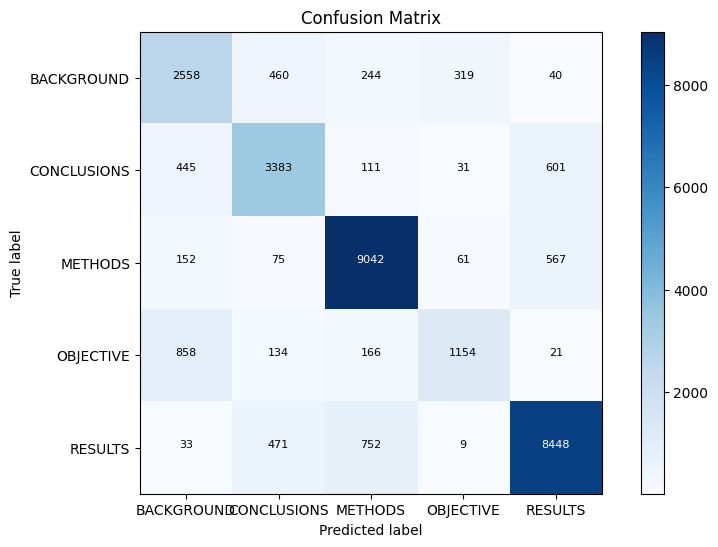

In [23]:
y_pred = np.argmax(model_2.predict(X_test),axis=1)

evaluate_model(y_test_encoded_label,y_pred,labels=labels.tolist())

In [24]:
# text = 'We present PubMed 200k RCT1, a new dataset based on PubMed for sequential sentence classification'
# print('Base model result =>',labels[model_0.predict([text])][0])
# print('LSTM model result =>',labels[np.argmax(model_1.predict([text],verbose=0),axis=1)[0]])
# print('CNN model result =>',labels[np.argmax(model_2.predict([text],verbose=0),axis=1)[0]])

### 3 Pretrained Embeddings

In [25]:
### GloVe

# !wget https://nlp.stanford.edu/data/glove.6B.zip

# hlp.unzip_data('glove.6B.zip')

# voc = tokenizer.get_vocabulary()

# word_index = dict(zip(voc, range(len(voc))))

# path_to_glove_file = "glove.6B.100d.txt"

# embeddings_index = {}
# with open(path_to_glove_file) as f:
#     for line in f:
#         word, coefs = line.split(maxsplit=1)
#         coefs = np.fromstring(coefs, "f", sep=" ")
#         embeddings_index[word] = coefs

# print("Found %s word vectors." % len(embeddings_index))


# num_tokens = len(voc) + 2
# embedding_dim = 100
# hits = 0
# misses = 0

# # Prepare embedding matrix
# embedding_matrix = np.zeros((num_tokens, embedding_dim))
# for word, i in word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         # Words not found in embedding index will be all-zeros.
#         # This includes the representation for "padding" and "OOV"
#         embedding_matrix[i] = embedding_vector
#         hits += 1
#     else:
#         misses += 1
# print("Converted %d words (%d misses)" % (hits, misses))

# embed_GloVe = tf.keras.layers.Embedding(input_dim = num_tokens,output_dim = embedding_dim,input_length = text_length)
# embed_GloVe.build((1,))
# embed_GloVe.set_weights([embedding_matrix])

# import tensorflow_hub as hub

# embed = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
#                        input_shape=[],
#                        dtype=tf.string,
#                        trainable = False)


In [26]:
import tensorflow_hub as hub

embed = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/large/versions/2",
                       input_shape=[])


In [27]:
# input = Input(shape=(),dtype=tf.string)
# x = embed(input)
# # x = Bidirectional(LSTM(64,return_sequences=True))(x)
# # x = GlobalMaxPool1D()(x)
# x = Dense(32,activation='relu')(x)
# output = Dense(5,activation='softmax')(x)
# model_3 = tf.keras.models.Model(input,output)

# # model_3.layers[2].trainable = False
# model_3.summary()

In [28]:
# model_3.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
# # model_3.fit(X_train,y_train_encoded_onehot,batch_size= 32*50,epochs=5,validation_data=(X_test,y_test_encoded_onehot))

### 4 Char level Embedding

In [29]:
# turn our data into char level !!
def text_to_char(text):
  return " ".join(list(text))

X_train_char = np.array(list(map(text_to_char, X_train)))
X_test_char = np.array(list(map(text_to_char, X_test)))
X_test_char[0]

't h i s   s t u d y   a n a l y z e d   l i v e r   f u n c t i o n   a b n o r m a l i t i e s   i n   h e a r t   f a i l u r e   p a t i e n t s   a d m i t t e d   w i t h   s e v e r e   a c u t e   d e c o m p e n s a t e d   h e a r t   f a i l u r e   (   a d h f   )   .'

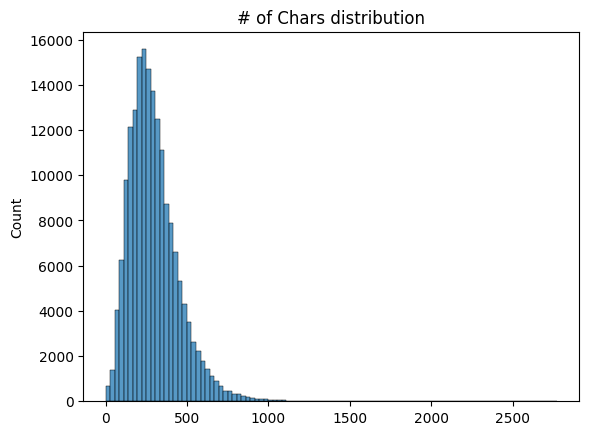

In [30]:
import seaborn as sns
sns.histplot([len(text) for text in X_train_char], bins=100)
plt.title('# of Chars distribution')
plt.show()


In [31]:
tokenizer_char = tf.keras.layers.experimental.preprocessing.TextVectorization(output_sequence_length=500)
tokenizer_char.adapt(X_train_char)

embed_char = tf.keras.layers.Embedding(input_dim = len(tokenizer_char.get_vocabulary()),output_dim=25)


In [32]:
np.array(tokenizer_char.get_vocabulary())

array(['', '[UNK]', 'e', 't', 'i', 'a', 'n', 'o', 'r', 's', 'd', 'c', 'l',
       'h', 'p', 'm', 'u', 'f', 'g', 'y', 'w', 'v', 'b', 'k', 'x', 'z',
       'q', 'j'], dtype='<U5')

In [33]:
# input = Input((),dtype= tf.string)
# x = tokenizer_char(input)
# x = embed_char(x)
# x = Bidirectional(LSTM(64,return_sequences=True))(x)
# x = GlobalMaxPool1D()(x)
# output = Dense(5,activation='softmax')(x)
# model_4 = tf.keras.models.Model(input,output)
# model_4.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
# model_4.summary()

In [34]:
# model_4.fit(X_train_char,y_train_encoded_onehot,batch_size = 32*100, epochs=3,validation_data=(X_test_char,y_test_encoded_onehot))


In [35]:
# model_4.fit(X_train_char,y_train_encoded_onehot,batch_size = 32*100, epochs=5,validation_data=(X_test_char,y_test_encoded_onehot))


In [36]:
# y_pred = np.argmax(model_4.predict(X_test_char),axis=1)

# evaluate_model(y_test_encoded_label,y_pred,labels=list(labels))

### 5 Hybrid (Pretrained Tokinized embedding + Char Embedding)

In [37]:
embed(['hello he is a boy']).shape

TensorShape([1, 512])

In [38]:
model_5_token = tf.keras.models.Sequential([
  Input(shape=(),dtype='string'),
  embed,
  Dense(128,activation='relu')
], 'Token_Embedding_Model')

model_5_char = tf.keras.models.Sequential([
  tokenizer_char,
  embed_char,
  Bidirectional(LSTM(24,return_sequences=True)),
  GlobalMaxPool1D()
], 'Char_Embedding_Model')

model_5_token.summary()
model_5_char.summary()

Model: "Token_Embedding_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               147354880 
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
Total params: 147420544 (562.36 MB)
Trainable params: 65664 (256.50 KB)
Non-trainable params: 147354880 (562.11 MB)
_________________________________________________________________
Model: "Char_Embedding_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 500)               0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (N

In [39]:
from tensorflow.keras import layers

input_token = Input((),dtype = 'string')
input_char = Input((),dtype='string')


output_token = model_5_token(input_token)
output_char = model_5_char(input_char)

output_concat = layers.Concatenate()([output_token,output_char])
x = layers.Dropout(0.5)(output_concat)
x = Dense(128,activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = Dense(5,activation='softmax')(x)

model_5 = tf.keras.models.Model([input_token,input_char],output)
model_5.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
model_5.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 Token_Embedding_Model (Seq  (None, 128)                  1474205   ['input_2[0][0]']             
 uential)                                                 44                                      
                                                                                                  
 Char_Embedding_Model (Sequ  (None, 48)                   10300     ['input_3[0][0]']         

In [40]:
from keras.utils import plot_model

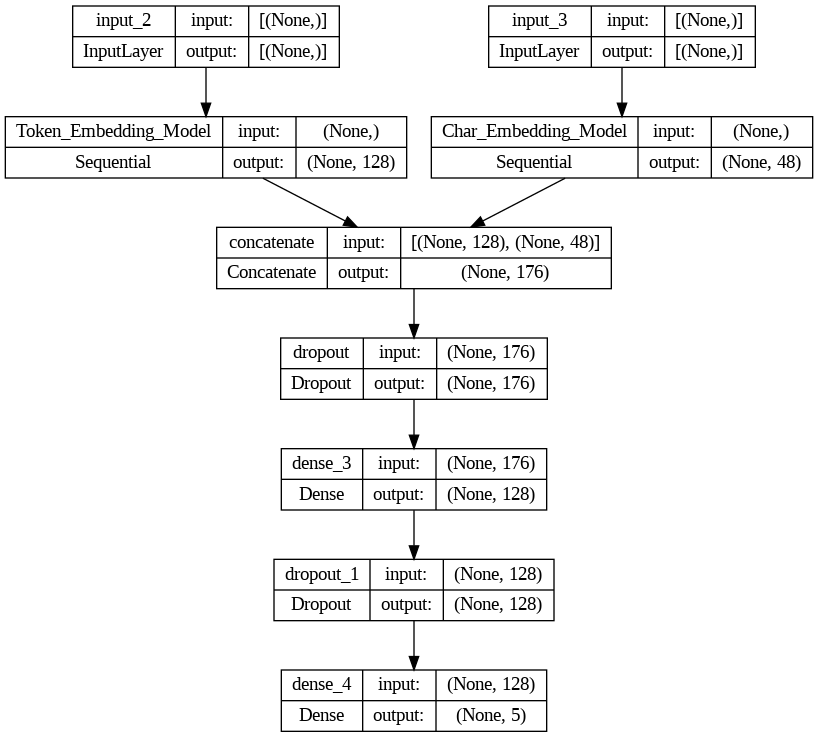

In [41]:
plot_model(model_5,show_shapes=True)

In [42]:
train_data = tf.data.Dataset.from_tensor_slices(((X_train,X_train_char),y_train_encoded_onehot)).batch(32*80)
test_data = tf.data.Dataset.from_tensor_slices(((X_test,X_test_char),y_test_encoded_onehot)).batch(32*80)

In [43]:
# model_5.fit(train_data, epochs=2, validation_data=test_data)

# 2 epochs Acc => 75% - 77%

Epoch 1/2


Exception ignored in: <function _xla_gc_callback at 0x7b76942b5630>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


KeyboardInterrupt: 

### 6 Hybrid Token + Char + Position

In [44]:
X_train_position = np.array([data for data in train_df[['line_no','total_lines']].values])
X_test_position = np.array([data for data in test_df[['line_no','total_lines']].values])


X_train_position.shape,X_test_position.shape

((180040, 2), (30135, 2))

In [45]:
# Token model
input_x = Input((),dtype='string')

## Option 1 (88% acc)
x = embed(input_x)
output_x = Dense(128,activation='relu')(x)

## option 2  (86% Fast)
# x = tokenizer(input_x)
# x = embedding(x)
# x = Bidirectional(LSTM(64,return_sequences=True))(x)
# output_x = GlobalMaxPool1D()(x)


model_6_tokenizer = tf.keras.models.Model(input_x,output_x,name='TokenizerModel')

# Char model
input_y = Input((),dtype='string')
y = tokenizer_char(input_y)
y = embed_char(y)
y = Bidirectional(LSTM(24,return_sequences=True))(y)
output_y = GlobalMaxPool1D()(y)
model_6_char = tf.keras.models.Model(input_y,output_y,name='CharModel')


# Concatinate Tokenizer & Char
concatinate_xy = layers.Concatenate()([output_x,output_y])
output_xy = Dense(128, activation='relu')(concatinate_xy)

model_6_xy = tf.keras.models.Model([input_x,input_y],output_xy)


# Positional model
input_z = Input((2),dtype=tf.float32)
output_z = Dense(24,activation='relu')(input_z)

# Concatinate xy with z
concatinate_xyz = layers.Concatenate()([output_xy,output_z])
xyz = Dense(128,activation='relu')(concatinate_xyz)
output_xyz = Dense(5,activation='softmax')(xyz)
model_6 = tf.keras.models.Model([input_x,input_y,input_z],output_xyz)

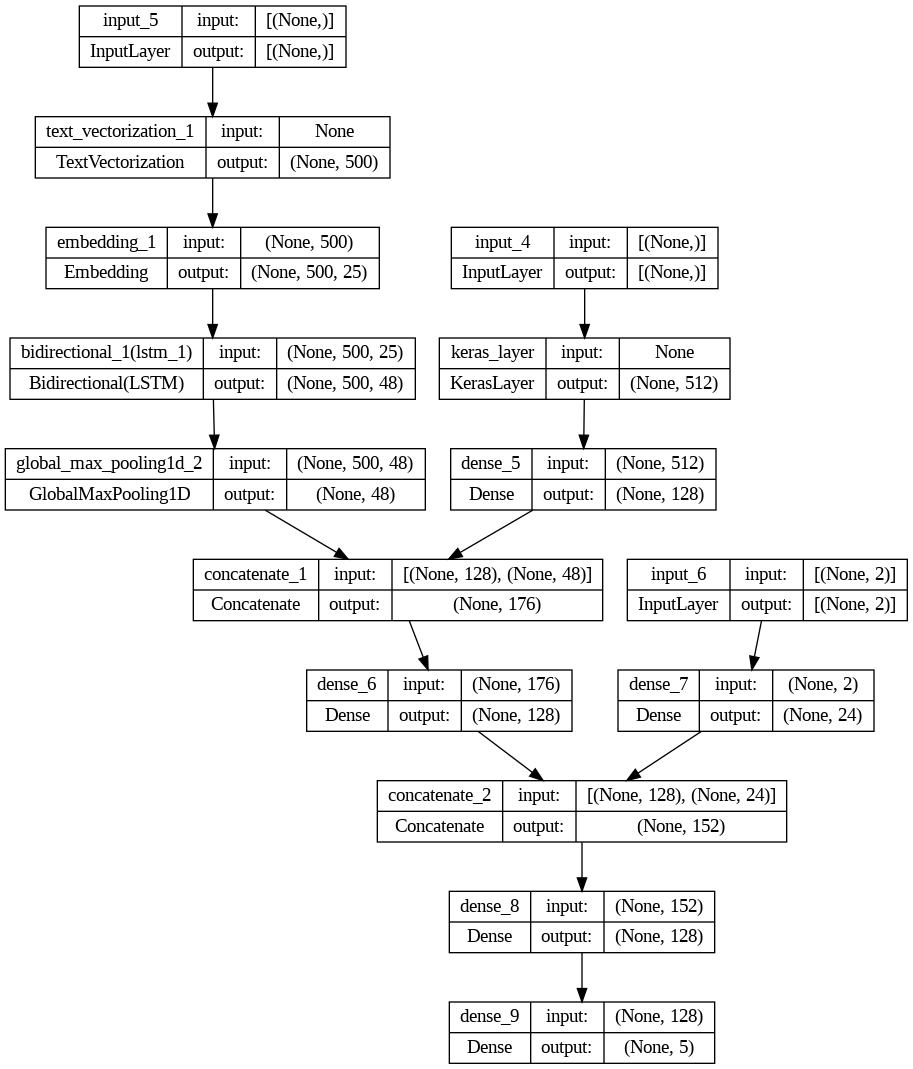

In [46]:
plot_model(model_6,show_shapes=True)

In [47]:
model_6.compile(loss=tf.losses.CategoricalCrossentropy(label_smoothing=0.2), optimizer = 'adam',metrics=['acc'])
model_6.fit(x = [X_train,X_train_char,X_train_position],
            y = y_train_encoded_onehot,
            epochs=5,
            batch_size=32*80,
            validation_data=((X_test,X_test_char,X_test_position),y_test_encoded_onehot))

Epoch 1/5
71/71 [==============================] - 164s 2s/step - loss: 1.1244 - acc: 0.6983 - val_loss: 0.9341 - val_acc: 0.8382
Epoch 2/5
71/71 [==============================] - 142s 2s/step - loss: 0.9018 - acc: 0.8571 - val_loss: 0.8863 - val_acc: 0.8651
Epoch 3/5
71/71 [==============================] - 144s 2s/step - loss: 0.8711 - acc: 0.8734 - val_loss: 0.8678 - val_acc: 0.8755
Epoch 4/5
71/71 [==============================] - 144s 2s/step - loss: 0.8555 - acc: 0.8819 - val_loss: 0.8563 - val_acc: 0.8806
Epoch 5/5
71/71 [==============================] - 141s 2s/step - loss: 0.8457 - acc: 0.8865 - val_loss: 0.8495 - val_acc: 0.8850


942/942 [==============================] - 64s 62ms/step
              precision    recall  f1-score   support

           0       0.74      0.84      0.79      3621
           1       0.92      0.91      0.92      4571
           2       0.90      0.95      0.92      9897
           3       0.77      0.56      0.65      2333
           4       0.93      0.90      0.91      9713

    accuracy                           0.89     30135
   macro avg       0.85      0.83      0.84     30135
weighted avg       0.88      0.89      0.88     30135

[[3057   38  165  351   10]
 [  43 4175   31    0  322]
 [ 101   43 9360   35  358]
 [ 895    0  130 1301    7]
 [   9  265  659    3 8777]]


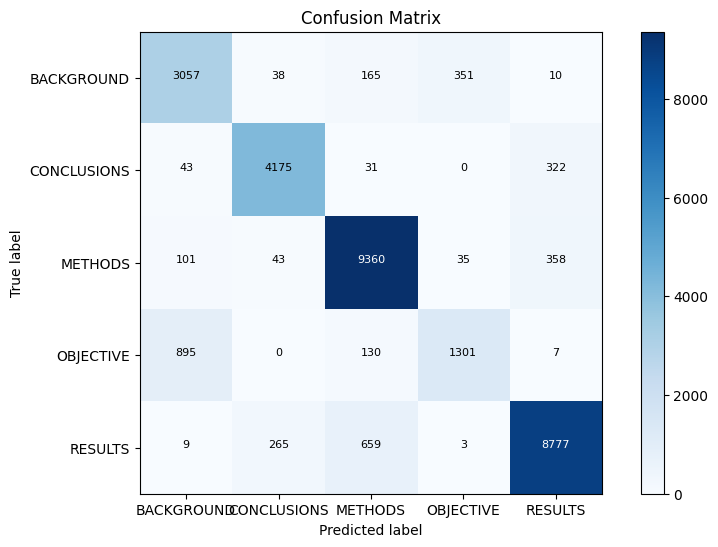

In [48]:
y_pred = np.argmax(model_6.predict([X_test,X_test_char,X_test_position]),axis=1)

evaluate_model(y_test_encoded_label,y_pred,labels=list(labels))